In [1]:
# plotting
import matplotlib.pyplot as plt

# arrays and math
import numpy as np

# image processing
import cv2

# opening files and paths
import os

from shapely_conversion import convert
from shapely_utilities import *

import spiral as S
from spiral import calculate_point, calculate_point_contour

import fermat_spiral as FS

# optimization module
from optimization import optimization

import time

In [2]:
'''
Plot a single path
'''
def plot_path(path, color=None):
    
    X = []
    Y = []

    for p in path:
        X.append(p[0])
        Y.append(p[1])
        
    plt.plot(X,Y,c=color)


'''
Plot a list of paths
'''
def plot_recursive_path(total_path, color=None):
    
    rest = []
    
    for path in total_path:
        if type(path) is list:
            plot_path(path, color)
        else:
            rest.append(path)
            
    plot_path(rest, color)

In [3]:
# this generates the total path without combining the paths
def generate_total_path(result, distance):
    
    total_path = []
    contour_family = []
    
    # loop through each value in the result
    for branch in result:
        if type(branch) is list:  
            total_path.extend(generate_total_path(branch, distance))
        else:
            contour_family.append(branch)

    results = S.execute(contour_family, distance)

    total_path.append(results)

    return total_path

In [4]:
# this generates the total path without combining the paths
def generate_total_pathf(result, distance):
    
    total_path = []
    contour_family = []
    
    # loop through each value in the result
    for branch in result:
        if type(branch) is list:  
            total_path.extend(generate_total_pathf(branch, distance))
        else:
            contour_family.append(branch)

    s_path = S.execute(contour_family, distance)
            
    results = FS.convert_fermat(s_path,distance)

    total_path.append(results)

    return total_path

In [5]:
# this creates a fermat path recursively from a tree of Polygon objects
def generate_fermat_path(result, distance):
    
    branches = []

    contour_family = []

    # loop through each node or branch in the tree
    for node in result:
        
        # if the result node is a branch, recursively call this function on it
        if type(node) is list:
            branches.append(generate_fermat_path(node, distance))
        # if the result node is not a branch, add it to the contour family
        else:
            contour_family.append(node)

    # generate the fermat spiral from the root and the branches
    root = FS.fermat_path(contour_family, distance,debug=False)

    # combine the root and the branches
    if root:
        return FS.combine_paths(root, branches, distance)
    
    # if there is no root (not sure how this happens but it does) - just return the branches?
    else:
        return branches

In [6]:
# execute runs the path function "fnc" on an image
# - use this to generate the path from an image
def execute(image, distance, fnc, optimize=False):
    
    opt_reg=1
    opt_smh=10
    opt_spacing=1
    
    total_path = []
    
    start = time.time()
    
    # create the polygons from the image
    polygons = convert(image, approximation = cv2.CHAIN_APPROX_SIMPLE)
    
    print("Polygon:", time.time()-start)
        
    # each individual polygon should be a separate distinct polygon in the image
    for polygon in polygons:
        
        '''
        Simplify the polygon first (all exterior and interiors)
        '''
        if optimize:
            
            optimize_time = time.time()
            
            ext = optimization(list(sample(polygon.exterior,10).coords), opt_reg, opt_smh, opt_spacing, False)

            ints = []

            for interior in polygon.interiors:
                ints.append(optimization(list(sample(interior,10).coords), opt_reg, opt_smh, opt_spacing, False))

            polygon = Polygon(ext, holes=ints)
            
            print("\tOptimize:", time.time()-optimize_time)
        
        
        dt_time = time.time()
        # generate the distance transform for the polygon
        result = distance_transform(polygon, -distance)
        
        print("\tDistance Transform:", time.time()-dt_time)
        
        
        path_time = time.time()
        
        # if there is a result, run the path generation function on the result
        if result:
            total_path.extend(fnc(result, distance))
            
        print("\tPath:", time.time()-path_time)
    
    print("Total:", time.time()-start)
    
    return total_path

True
Polygon: 0.003951549530029297
	Optimize: 0.07966995239257812
	Distance Transform: 0.007626056671142578
	Spiral 0.12280797958374023
	Duplicates 0.00026106834411621094
	Remove Intersections 0.0017578601837158203
	Spiral 0.0004754066467285156
	Duplicates 3.814697265625e-06
	Remove Intersections 0.0002048015594482422
	Spiral 0.003526449203491211
	Duplicates 1.8358230590820312e-05
	Remove Intersections 0.0002617835998535156
	Spiral 0.0009713172912597656
	Duplicates 3.337860107421875e-06
	Remove Intersections 2.7179718017578125e-05
	Spiral 0.05426645278930664
	Duplicates 0.00014162063598632812
	Remove Intersections 0.0010263919830322266
	Path: 0.18626737594604492
Total: 0.2778942584991455


<IPython.core.display.Javascript object>


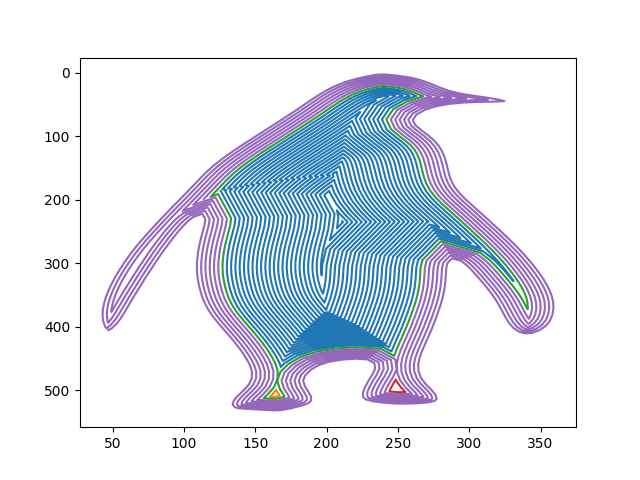

CPU times: user 477 ms, sys: 710 ms, total: 1.19 s
Wall time: 303 ms


In [34]:
%%time
%matplotlib notebook
'''
This cell runs the complete pipeline from image to CFS output
'''

# distance in between each contour
distance = 3

# filename of image to process
filename = 'files/penguin.png'

# image should be in binary format
image = cv2.imread(filename,0)

print(not image is None)

# generate the un-connected fermat spiral output
# settings: simplify - True, optimize - False (flip this to true to see effect), optimize locally - True
#           penalize points for moving away from their original position: 1
#           penalize points for violating mid-point scheme: 5
#           spacing penalization is not implemented yet. The last term means nothing for now
results = execute(image, distance, generate_total_path, True)
# plot and show the path
plot_recursive_path(results)
plt.gca().invert_yaxis()
plt.show()

In [8]:

from gcode import GcodeWriter

In [9]:
gc = GcodeWriter(filename='wolf.gcode', scale = 0.1)

gc.convert([results])

'G28 Z;\nG01 Z0.5;\nG28 X Y;\n\nG00 X9.549500534230274 Y2.3347514742749875;\nG01 Z8.0\nG01 X9.39326619339105 Y2.4724937382475902;\nG01 X8.782717660825755 Y3.102711474094452;\nG01 X8.293958485803964 Y3.7389413798570894;\nG01 X7.859707800949599 Y4.445713120648679;\nG01 X7.495679284729238 Y5.196839184386122;\nG01 X7.215221632715821 Y5.98212799154236;\nG01 X6.994391133991271 Y6.816564598583351;\nG01 X6.768427816664384 Y7.788150592974496;\nG01 X6.37896560736199 Y8.84203805421941;\nG01 X5.61634043753451 Y9.709570277600656;\nG01 X4.626035579026764 Y10.146756779826081;\nG01 X5.029897933936853 Y11.061576542558871;\nG01 X5.234817519417014 Y10.97111139332336;\nG01 X5.6378880840834205 Y11.88628070498965;\nG01 X6.020332343367212 Y12.433494730339335;\nG01 X6.6895386696351045 Y13.560763157765434;\nG01 X7.212971678221701 Y14.88132544849632;\nG01 X7.490505499509704 Y16.270890364299305;\nG01 X7.547254038302322 Y17.582415349276;\nG01 X7.4942989432404294 Y18.746117499992163;\nG01 X7.3874976094376015 Y19.8

In [10]:
LineString()

In [11]:
polygon = convert(image, 5)[0]

In [12]:
ls = polygon.exterior


opt_reg = 1
opt_smh = 200
opt_spacing = 1
opt_local = True


# test optimization on input image
opt = optimization(list(ls.coords), opt_reg, opt_smh, opt_spacing, False)

#plot_path(list(ls.coords))
plot_path(opt)

In [13]:
# test optimization on advanced image
# test optimization on input image
opt = optimization(list(sample(ls,3).coords), opt_reg, opt_smh, opt_spacing, False)

#plot_path(list(ls.coords))
plot_path(opt)

In [14]:
LineString(results).is_simple

True

In [15]:
# helper function to display the format of the "result" tree
# - the "result" tree is the representation of the distance transform 
# - EX: A tree of "['X','X','X', ['X',['X','X'], ['X']], ['X']]" has...
# 1. Three successive outer contours (no branches)
# 2. A branch with a single contour with a depth-2 branch and a depth-1 branch
# 3. A branch with a single contour

# TODO there is probably a better way to set up the trees in this scenario
def simplify_tree(result):
    
    root = []
    output = []
    for b in result:
        if type(b) is list:
            output.append(simplify_tree(b))
            
    return ["X"] + output

In [16]:
def remove_short_paths(temp_path, length=20):
    
    clean_path = []
    
    for path in temp_path:
        
        if LineString(path).length > length:
            clean_path.append(path)
    
    return clean_path

In [17]:
# execute runs the path function "fnc" on an image
# - use this to generate the path from an image
def execute_backup(image, distance, fnc, simplify=True, optimize=False, optimize_local=True, opt_reg=1, opt_smh=200, opt_spacing=1):
    
    total_path = []
    
    # create the polygons from the image
    polygons = convert(image, approximation = cv2.CHAIN_APPROX_SIMPLE)
        
    # each individual polygon should be a separate distinct polygon in the image
    for polygon in polygons:
        
        
        '''
        Simplify the polygon first (all exterior and interiors)
        '''
        ext = optimization(list(sample(polygon.exterior,3).coords), opt_reg, opt_smh, opt_spacing, False)
        
        interiors = []
        
        for i in polygon.interiors:
            interiors.append(optimization(list(sample(polygon.exterior,3).coords), opt_reg, opt_smh, opt_spacing, False))
        
        
        
        # simplify the polygon to remove excess points - this helps with processing
        if simplify:
            polygon = polygon.simplify(distance/2)
        
        # generate the distance transform for the polygon
        result = distance_transform(polygon, -distance)
        
        # optimize each contour locally
        if optimize and optimize_local:
            for i in range(len(result)):
                result[i] = optimization(result[i], opt_reg, opt_smh, opt_spacing, optimize_local)
        
        # if there is a result, run the path generation function on the result
        if result:
            total_path.extend(fnc(result, distance))
            
    # optimize output path globally
    if optimize and not optimize_local:
        total_path = optimization(total_path, opt_reg, opt_smh, opt_spacing, optimize_local)
    
    return total_path